In [1]:
import os
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn

In [2]:
#from factory.LstmDV import LstmDV as D_VECTOR
from factory.MetaDV import MetaDV as D_VECTOR

In [3]:
ROOT = 'test_spmel_vctk'
erroment_uttr_idx = 4
max_uttr_idx = 9

In [4]:
num_speaker = 10

In [5]:
all_speaker = next(iter(os.walk(f'{ROOT}')))[1]
num_speaker= int(len(all_speaker))
result = np.zeros((num_speaker,num_speaker))
C = torch.load('metadv_en_ver2.pt')

In [6]:
all_speaker

['p345',
 'p347',
 'p351',
 'p360',
 'p361',
 'p362',
 'p363',
 'p364',
 'p374',
 'p376']

In [7]:
all_dv = []
for id_,speaker in enumerate(all_speaker):
    all_uttr = next(iter(os.walk(f'{ROOT}/{speaker}')))[2][:erroment_uttr_idx]
    tmp_dv = torch.zeros((1,256))
    for uttr in all_uttr:
        mel = torch.from_numpy(np.load(f'{ROOT}/{speaker}/{uttr}')).unsqueeze(0).cuda()
        tmp_dv += C(mel)[1].detach().cpu()
    all_dv.append( [tmp_dv/(erroment_uttr_idx+1),speaker,id_])

## Muticlass

In [8]:
thresholds = np.arange(0,1.01,0.01).astype(np.float32)

In [9]:
cos_reslut = np.zeros((num_speaker,num_speaker))
result = np.zeros((101,num_speaker,4))
for dv,speaker_s,i in all_dv:
    print(f"Now Processing --- {speaker_s}")
    for _,speaker_t,j in all_dv:  
        # 採 5 句
        for _ in range(5):
            random_uttr = next(iter(os.walk(f'{ROOT}/{speaker_t}')))[2][random.randint(erroment_uttr_idx,max_uttr_idx)]
            mel = torch.from_numpy(np.load(f'{ROOT}/{speaker_t}/{random_uttr}')).unsqueeze(0).cuda()
            t_dv = C(mel)[1].detach().cpu()
            cos = nn.functional.cosine_similarity(dv,t_dv, dim=1, eps=1e-8).detach().numpy()[0].astype(np.float32)
            if cos < 0.0:
                cos = 0.0
            cos_reslut[i][j] = cos
            for k,threshold in enumerate(thresholds):
                if cos >= threshold: 
                    if i ==j:
                        # TP
                        result[k][i][0] += 1
                    else:
                        # FP
                        result[k][i][1] += 1
                else:
                    if i == j:
                        # FN
                        result[k][i][2] += 1
                    else:
                        # TN
                        result[k][i][3] += 1

Now Processing --- p345
Now Processing --- p347
Now Processing --- p351
Now Processing --- p360
Now Processing --- p361
Now Processing --- p362
Now Processing --- p363
Now Processing --- p364
Now Processing --- p374
Now Processing --- p376


In [10]:
all_FNR,all_FPR = [],[]
for res in result:
    _fpr = 0.0
    _fnr = 0.0
    for sp_res in res:
        _fnr += sp_res[2]/(sp_res[0]+sp_res[2])
        _fpr += sp_res[1]/(sp_res[1]+sp_res[3])
    all_FNR.append(_fnr/len(res))
    all_FPR.append(_fpr/len(res))

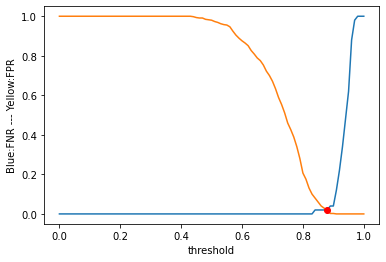

In [11]:
import matplotlib.pyplot as plt
from shapely.geometry import  LineString
%matplotlib inline

line_1 = LineString(np.column_stack((thresholds, all_FNR)))
line_2 = LineString(np.column_stack((thresholds, all_FPR)))
intersection = line_1.intersection(line_2)
plt.plot(thresholds,all_FNR)
plt.plot(thresholds,all_FPR)
plt.plot(*intersection.xy, 'ro')
plt.xlabel('threshold')
plt.ylabel('Blue:FNR --- Yellow:FPR')
plt.show()

In [12]:
print(*intersection.xy)

array('d', [0.8799999952316284]) array('d', [0.02])


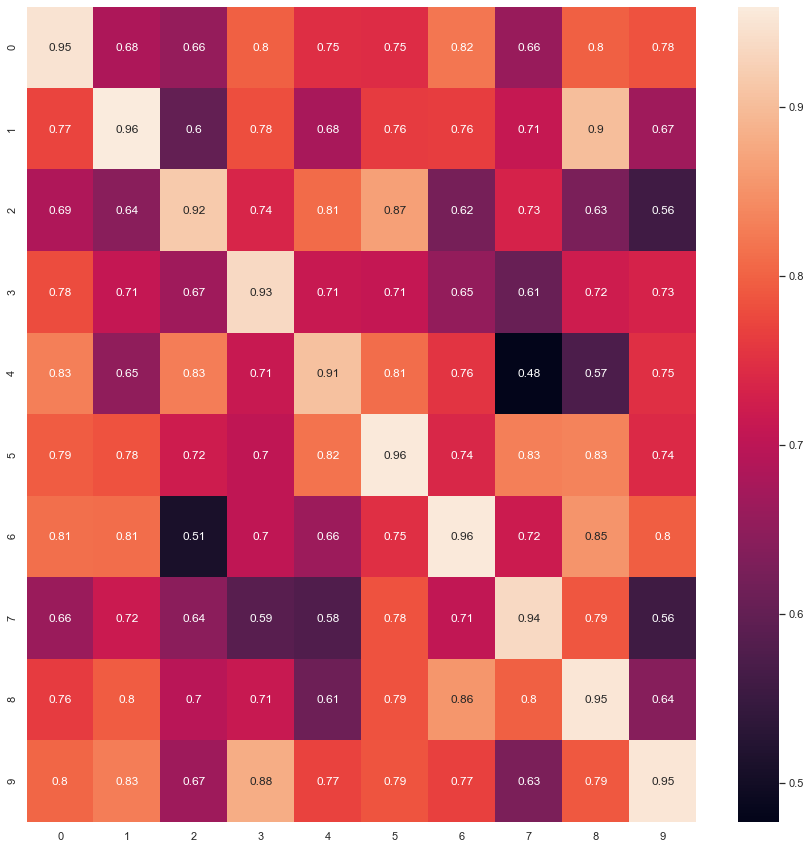

In [13]:
import seaborn as sns; sns.set_theme()
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cos_reslut, annot=True)